##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# FGSM を使用した敵対的サンプル

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/adversarial_fgsm">     <img src="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/tutorials/generative/adversarial_fgsm.ipynb">     TensorFlow.org で表示</a> </td>
  <td> <img src="https://www.tensorflow.org/images/colab_logo_32px.png"><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/tutorials/generative/adversarial_fgsm.ipynb">Google Colab で実行</a> </td>
  <td> <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png"><a target="_blank" href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/tutorials/generative/adversarial_fgsm.ipynb">GitHub でソースを表示</a> </td>
  <td> <img src="https://www.tensorflow.org/images/download_logo_32px.png"><a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/adversarial_fgsm.ipynb">ノートブックをダウンロード</a> </td>
</table>

このチュートリアルでは、Goodfellow *など*が [Explaining and Harnessing Adversarial Examples](https://arxiv.org/abs/1412.6572) で説明する FGSM（Fast Gradient Signed Method）攻撃を使用して、*敵対的サンプル* を作成します。この攻撃は、ニューラルネットワークを騙した初の、広く使用される攻撃の 1 つです。

## 敵対的サンプルとは？

敵対的サンプルとは、ニューラルネットワークを混乱させて、ある入力が誤分類されることを目的に作成される特殊な入力です。このような悪名高い入力は人の目で区別できるものではありませんが、ネットワークが画像のコンテンツを識別できなくしてしまいます。このような攻撃にはいくつかの種類がありますが、ここでは、FGSM 攻撃という、誤分類を実現する目的を持つ*ホワイトボックス*攻撃に焦点を当てています。ホワイトボックス攻撃は、攻撃者が攻撃を受けるモデルに完全にアクセスできる状況を指します。以下に示される敵対的画像の最も有名な例の 1 つは、上記の資料から取得したものです。

![Adversarial Example](images/adversarial_example.png)

ここでは、攻撃者はパンダの画像から始め、元の画像に小さな摂動（歪み）を追加し、その結果、モデルは高信頼度でこの画像をテナガザルとして分類するようになります。この摂動の追加プロセスについて、以下で説明しています。

## FGSM（Fast Gradient Sign Method）

FGSM は、ニューラルネットワークの勾配を利用して敵対的サンプルを作成する手法です。入力画像に対し、入力画像に関する損失の勾配を使用して、その損失を最大化する新しい画像を作成します。この新しい画像は敵対的画像と呼ばれ、次の式を使って要約されます。$$adv_x = x + \epsilon*\text{sign}(\nabla_xJ(\theta, x, y))$$

次のように解釈します。

- adv_x : 敵対的画像
- x : 元の入力画像
- y : 元の入力ラベル
- $\epsilon$ : 小さな摂動を確実にするための乗数
- $\theta$ : モデルのパラメータ
- $J$ : 損失

ここで興味深い特性は、勾配が入力画像に関して取られているということです。これは、損失を最大化する画像を作成することを目的としているために行われています。画像内の各ピクセルがどれくらい損失値に貢献しているかを求め、それに応じて摂動を追加することで、これを達成しています。チェーンルールを使用して必要な勾配を見つけることで、各ピクセルの損失への貢献度を簡単に求めることができるため、非常に高速に処理することができます。したがって、勾配は画像に関して取られます。さらに、モデルはトレーニングされなくなるため（したがって、モデルパラメータであるトレーニング可能な変数に関して勾配が取られない）、モデルパラメータは一定したままになります。トレーニング済みのモデルを騙すことが唯一の目標です。

では、トレーニング済みのモデルを騙してみましょう。このチュートリアルでは、[ImageNet](http://www.image-net.org/) で事前にトレーニングされた [MobileNetV2](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/applications/MobileNetV2) モデルを使用します。

In [2]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

2024-01-11 22:39:05.884713: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-11 22:39:05.884757: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-11 22:39:05.886511: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


トレーニング済みの MobileNetV2 モデルと ImageNet クラス名を読み込みましょう。

In [3]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

    8192/14536120 [..............................] - ETA: 0s

 4202496/14536120 [=======>......................] - ETA: 0s

14536120/14536120 [==============================] - 0s 0us/step


In [4]:
# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

## 元の画像

ウィキペディアコモンズにある [ラブラドールレトリバー](https://commons.wikimedia.org/wiki/File:YellowLabradorLooking_new.jpg)（Mirko [CC-BY-SA 3.0](https://creativecommons.org/licenses/by-sa/3.0/)）のサンプル画像を使用して、敵対的サンプルを作成しましょう。この画像を事前処理し、MobileNetV2 モデルに入力としてフィードできるようにします。

In [5]:
image_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 2s 2s/step


画像を見てみましょう。

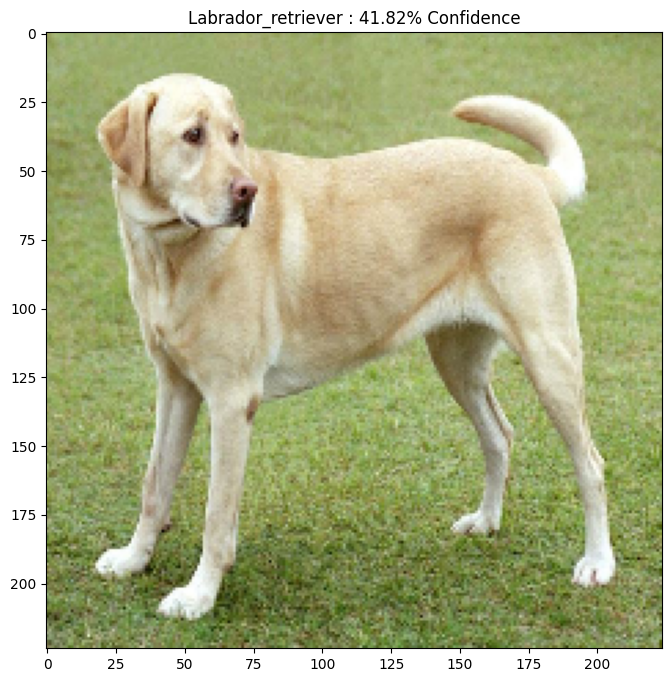

In [6]:
plt.figure()
plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

## 敵対的画像を作成する

### FGSM を実装する

まず、元の画像に歪ませて敵対的画像を生成するための摂動を作成します。すでに説明したように、このタスクでは、画像に関する勾配が取られます。

In [7]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

これで得られた摂動を視覚化することもできます。

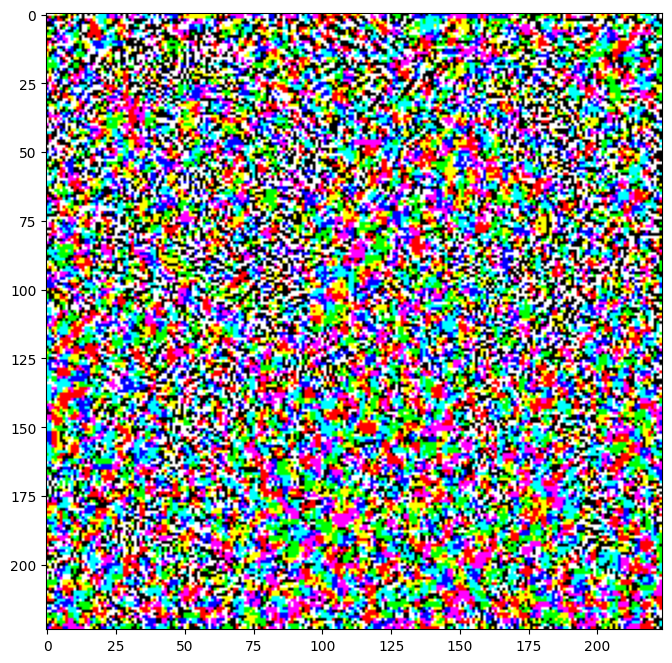

In [8]:
# Get the input label of the image.
labrador_retriever_index = 208
label = tf.one_hot(labrador_retriever_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

別の epsilon の値を使って、画像の変化を観察しましょう。epsilon の値が増加するにつれ、ネットワークを騙しやすくなるのがわかると思います。ただし、これには、摂動が識別しやすくなるというトレードオフがあります。

In [9]:
def display_images(image, description):
  _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
  plt.show()

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 50ms/step


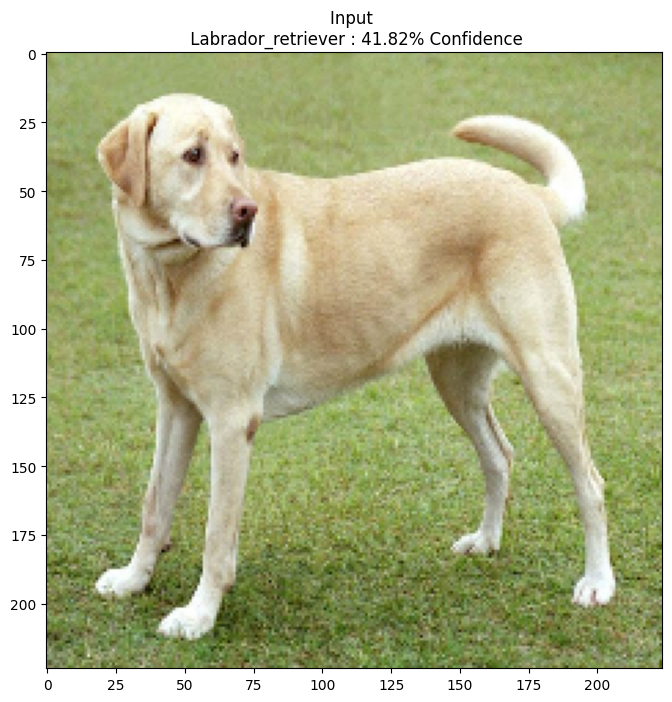

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 50ms/step


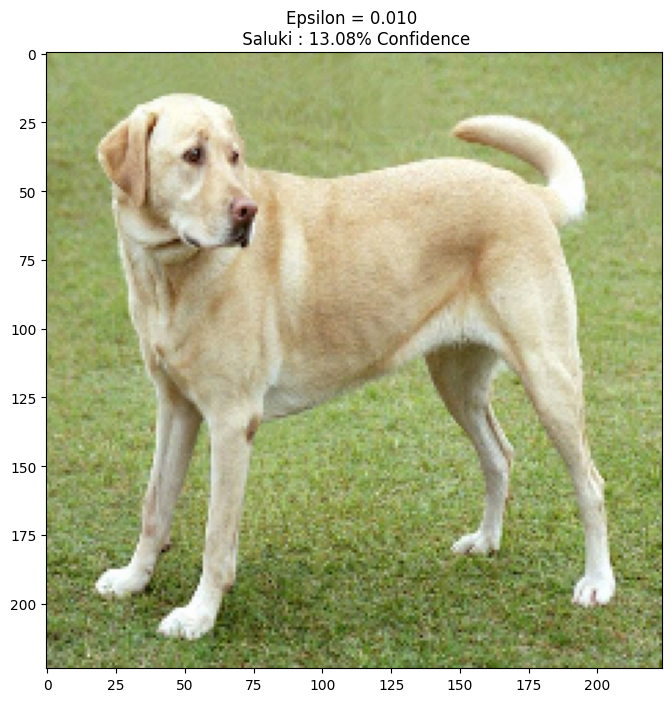

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 48ms/step


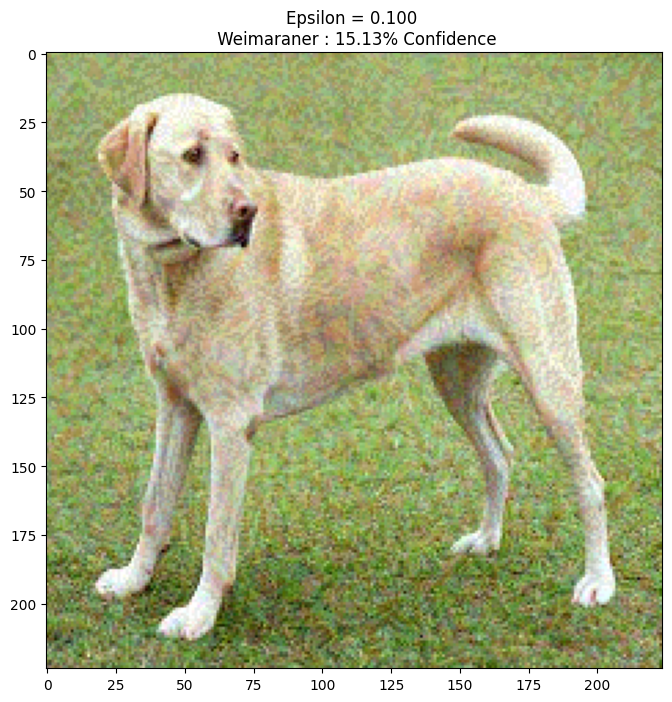

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 49ms/step


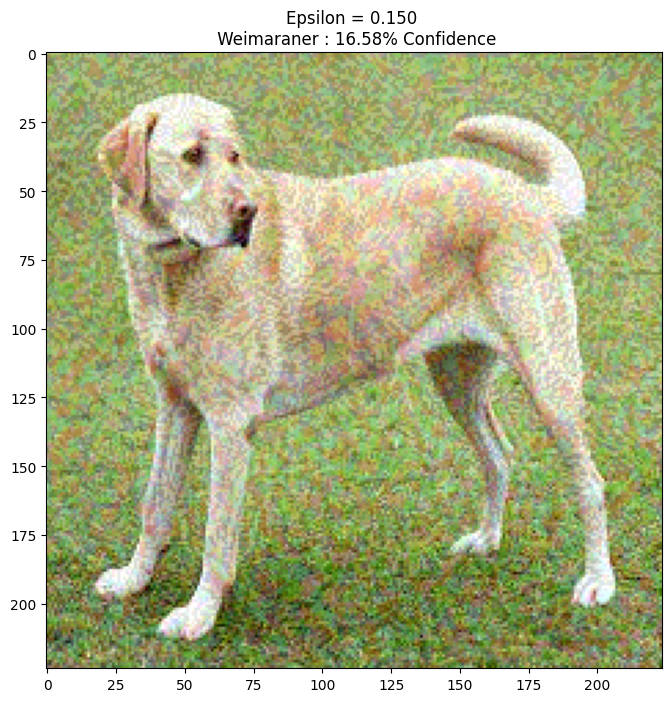

In [10]:
epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, descriptions[i])

## 次のステップ

敵対的攻撃について理解できたので、ほかのデータベースやほかのアーキテクチャで試してみましょう。独自のモデルを作成してトレーニングしてから、同じ手法でそれを騙してみてもよいでしょう。また、epsilon を変更するにつれ、予測の信頼性がどのように変化するかを見てみるのもよいでしょう。

このチュートリアルで紹介した攻撃は強力ですが、敵対的攻撃の研究の手始めにすぎません。これが明るみに出て以来、より強力な攻撃を作り出す多数の論文が発表されています。研究は、敵対的攻撃だけでなく、堅牢な機械学習モデルを作り出すことを目的に防衛をも生み出しています。敵対的攻撃と防衛の包括的なリストについては、こちらの[調査論文](https://arxiv.org/abs/1810.00069)をご覧ください。

その他の敵対的攻撃と防衛の実装については、[CleverHans](https://github.com/tensorflow/cleverhans) という敵対的サンプルライブラリをご覧ください。